# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
from tensorflow.keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.weights = tf.Variable(tf.random.normal([in_features, out_features], stddev=0.1), name="weights")
        self.bias = tf.Variable(tf.zeros([out_features]), name="bias")

    def __call__(self, x):
        linear_output = tf.add(tf.matmul(x, self.weights), self.bias)
        return tf.nn.relu(linear_output)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        
        # Вихідний шар
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        # Прямий прохід через перший шар
        x = self.layer1(x)
        
        # Прямий прохід через другий шар
        x = self.layer2(x)
        
        # Прямий прохід через вихідний шар
        x = self.out_layer(x)
        
        # Застосування функції softmax до виходу
        return tf.nn.softmax(x)

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Знаходимо індекс класу з найбільшою ймовірністю для передбачення
    predicted_class = tf.argmax(y_pred, 1)
    
    # Перевіряємо, чи передбачені класи збігаються з істинними
    correct_predictions = tf.equal(predicted_class, tf.cast(y_true, tf.int64))
    
    # Обчислюємо середню точність
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(nn, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Створимо список оптимізованих параметрів
        trainable_variables = neural_net.trainable_variables

        # Обчислимо за ними значення градієнта
        gradients = g.gradient(loss, trainable_variables)

        # Модифікуємо параметри
        optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        
        # Зберігання значень функції втрат та точності
        loss_history.append(loss)
        accuracy_history.append(acc)
        
        print(f"step: {step}, loss: {loss}, accuracy: {acc}")

step: 0, loss: 588.3533935546875, accuracy: 0.17578125
step: 100, loss: 203.673095703125, accuracy: 0.8046875
step: 200, loss: 46.621482849121094, accuracy: 0.94921875
step: 300, loss: 31.411865234375, accuracy: 0.97265625
step: 400, loss: 35.081600189208984, accuracy: 0.96875
step: 500, loss: 20.211545944213867, accuracy: 0.9765625
step: 600, loss: 20.079992294311523, accuracy: 0.98046875
step: 700, loss: 14.371831893920898, accuracy: 0.98828125
step: 800, loss: 21.642242431640625, accuracy: 0.98046875
step: 900, loss: 12.67225456237793, accuracy: 0.98828125
step: 1000, loss: 18.589982986450195, accuracy: 0.984375
step: 1100, loss: 20.16040802001953, accuracy: 0.9765625
step: 1200, loss: 13.434610366821289, accuracy: 0.98828125
step: 1300, loss: 5.222172737121582, accuracy: 0.99609375
step: 1400, loss: 13.048213005065918, accuracy: 0.98828125
step: 1500, loss: 14.294193267822266, accuracy: 0.984375
step: 1600, loss: 12.154664039611816, accuracy: 0.9921875
step: 1700, loss: 4.479036331

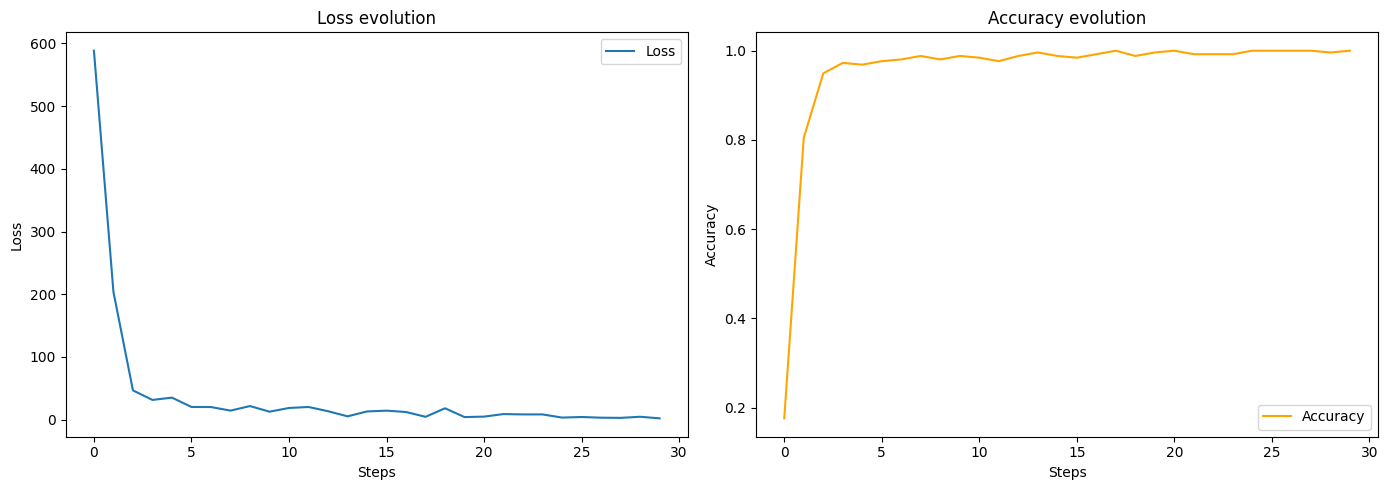

In [8]:
import matplotlib.pyplot as plt

# Графік залежності втрат від кроку
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Loss evolution')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Графік залежності точності від кроку
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy', color='orange')
plt.title('Accuracy evolution')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Передбачення моделі на тестовому наборі даних
y_pred = neural_net(x_test)
predicted_classes = tf.argmax(y_pred, axis=1)

# Метрики
accuracy_metric = tf.metrics.Accuracy()
precision_metric = tf.metrics.Precision()
recall_metric = tf.metrics.Recall()

# Обновлюємо метрики
accuracy_metric.update_state(y_test, predicted_classes)
precision_metric.update_state(y_test, predicted_classes)
recall_metric.update_state(y_test, predicted_classes)

# Отримуємо значення метрик
accuracy_value = accuracy_metric.result().numpy()
precision_value = precision_metric.result().numpy()
recall_value = recall_metric.result().numpy()

print(f"Accuracy: {accuracy_value}")
print(f"Precision: {precision_value}")
print(f"Recall: {recall_value}")


Accuracy: 0.9750999808311462
Precision: 0.9986693263053894
Recall: 0.9984478950500488


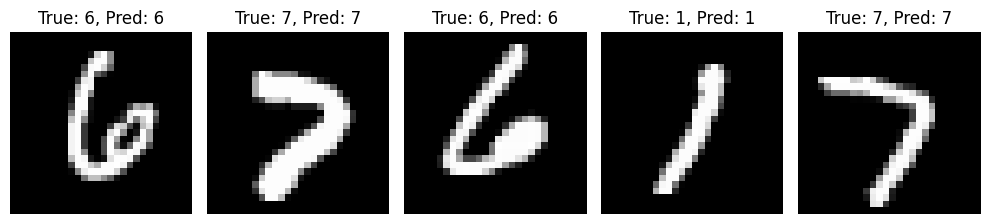

In [13]:
import numpy as np

# Вибираємо 5 випадкових індексів
random_indices = np.random.choice(len(x_test), 5)

# Вибираємо зображення та істинні мітки за цими індексами
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

# Отримуємо передбачення мережі
predictions = neural_net(random_images)
predicted_classes = np.argmax(predictions, axis=1)

# Виведення результатів
plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(random_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {random_labels[i]}, Pred: {predicted_classes[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
